# From DP to FE
Rewrite all the data cleaning, data preprocessing and generation utilities to align inference phase.


## Ref
https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt/notebook

## Import Packages

In [2]:
%load_ext autoreload
%autoreload 2
import json
import re
import math
import pickle
import warnings
from datetime import datetime, timedelta
from pathlib import Path
from typing import Any, Dict, List, Optional, Union, Tuple, Iterator
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from polars.testing import assert_series_equal
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GroupKFold
from matplotlib.axes import Axes

from metadata import *
from cv.build import TSCV

pd.options.display.max_columns = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class CFG:
    load_proc_df = False
    
    tgt_col = "target"
    fill_wth_null = False

In [4]:
!cat metadata.py

"""
Project metadata for global access.
Author: JiaWei
"""
import polars as pl

# == Data ==
UNIT_ID_COL = "prediction_unit_id"
TGT_COL = "target"
DBI = "data_block_id"
TGT_PK_COLS = ["county", "is_business", "product_type"]
REVEALED_TGT_COLS = [UNIT_ID_COL, "datetime", TGT_COL, "is_consumption"]
COORD_COL2ABBR = {"latitude": "lat", "longitude": "lon"}
LOC_COLS = ["lat", "lon"]
PRODUCT_TYPE2NAME = {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}

# == Join keys ==
CLI_JOIN_KEYS = ["county", "is_business", "product_type", "date"]
# FWTH_JOIN_KEYS = ["county", "datetime"]
# HWTH_JOIN_KEYS = ["county", "datetime"]
REVEALED_TGT_JOIN_KEYS = [UNIT_ID_COL, "datetime", "is_consumption"]
REVEALED_TGT_ROLLING_JOIN_KEYS = [UNIT_ID_COL, "datetime", "is_consumption"]

# == Groupby keys ==
FWTH_LGP_KEYS = ["county", "datetime", DBI]
FWTH_GGP_KEYS = ["datetime", DBI]

HWTH_LGP_KEYS = ["county", "datetime"]
HWTH_GGP_KEYS = ["datetime"]
REVEALED_TGT_ROLLING_GP_KEYS = [UNIT_ID_COL, "is_consu

## Define Local Data Paths

In [5]:
RAW_DATA_PATH = Path("./data/raw/")
PROC_DATA_PATH = Path("./data/processed/")

## Define Utilities

In [6]:
def _reduce_memory_usage(
    df: pl.DataFrame, 
    cols_to_skip: List[str] = [],
    data_name: str = ""
) -> pl.DataFrame:
    """Reduce memory usage by dtype casting.
    
    Args:
        df: raw DataFrame
        cols_to_skip: columns to skip dtype casting
    
    Returns:
        df: DataFrame with reduced memory footprint
    """
    start_mem = df.estimated_size("mb")
    print(f"Memory usage of {data_name} DataFrame is {start_mem:.2f} MB.")
    
    # pl.Uint8, pl.UInt16, pl.UInt32, pl.UInt64
    NUM_INT_TYPES = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    NUM_FLOAT_TYPES = [pl.Float32, pl.Float64]
    for col in df.columns:
        if col in cols_to_skip: continue
        
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in NUM_INT_TYPES:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in NUM_FLOAT_TYPES:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    end_mem = df.estimated_size("mb")
    print(f"Memory usage became: {end_mem:.2f} MB.")
    print(f"-> Total {(start_mem-end_mem) / start_mem * 100}% reduced.")
    

    return df

In [7]:
def _shift_and_join(
    ldf: Union[pl.DataFrame, pl.LazyFrame],
    rdf: Union[pl.DataFrame, pl.LazyFrame],
    join_keys: List[str],
    dt_col: str,
    feats: List[str],
    shift_amt: str
) -> Tuple[Union[pl.DataFrame, pl.LazyFrame], List[str]]:
    """Perform DataFrame join with the shifted features.
    
    Left DataFrame is usually the main DataFrame, but this utility can
    also be used to extend multiple lookbacks of a homogeneous feat.
    
    Args:
        ldf: left DataFrame, usually the main DataFrame
        rdf: right DataFrame
        join_keys: join keys
        dt_col: datetime column, either "datetime" or "date"
        feats: feature list
        shift_amt: shift amount (e.g., 1h, 2d)
            *Note: Only "h" and "d" are supported.
        
    Returns:
        df: joined DataFrame
        new_feats: new feature list
    """
    shift_amt_val = int(shift_amt[:-1])
    feat_suffix = f"lag{shift_amt}" if shift_amt_val != 0 else "cur"
    feats_map = {feat: f"{feat}_{feat_suffix}" for feat in feats}
    
    if shift_amt_val != 0:
        if shift_amt[-1] == "h":
            # Hour resolution
            shifted_dt = pl.col(dt_col) + pl.duration(hours=shift_amt_val)
        elif shift_amt[-1] == "d":    
            # Day resolution
            shifted_dt = pl.col(dt_col) + pl.duration(days=shift_amt_val)
        if dt_col == "date":
            shifted_dt = shifted_dt.cast(pl.Date)
        rdf = rdf.with_columns(shifted_dt)
    df = (
        ldf
        .join(rdf, on=join_keys, how="left")
        .rename(feats_map)
    )
    new_feats = list(feats_map.values())
    
    return df, new_feats

In [8]:
def _get_fillnul_exprs(dst_cols: List[str], src_cols: List[str]) -> List[pl.Expr]:
    """Return expressions of null filling logics, from source column to
    destination column.
    
    Args:
        dst_cols: destination column list
        src_cols: source column list
        
    Returns:
        fillnul_exprs: expressions of null filling logics
    """
    fillnul_exprs = [
        pl.when(pl.col(dst_col).is_null())
            .then(pl.col(src_col))
            .otherwise(pl.col(dst_col)).alias(dst_col) for dst_col, src_col in zip(dst_cols, src_cols)
    ]
    
    return fillnul_exprs

## Load Data

In [9]:
if not CFG.load_proc_df:
    train = pl.read_csv(RAW_DATA_PATH / "train.csv", try_parse_dates=True)
    client = pl.read_csv(RAW_DATA_PATH / "client.csv", try_parse_dates=True)
    fwth = pl.read_csv(RAW_DATA_PATH / "forecast_weather.csv", try_parse_dates=True)
    hwth = pl.read_csv(RAW_DATA_PATH / "historical_weather.csv", try_parse_dates=True)
    elec = pl.read_csv(RAW_DATA_PATH / "electricity_prices.csv", try_parse_dates=True)
    gas = pl.read_csv(RAW_DATA_PATH / "gas_prices.csv", try_parse_dates=True)
else:
    train = pl.read_parquet(PROC_DATA_PATH / "data_eager_new.parquet")

In [10]:
train.columns

['county',
 'is_business',
 'product_type',
 'target',
 'is_consumption',
 'datetime',
 'data_block_id',
 'row_id',
 'prediction_unit_id']

In [11]:
client.columns

['product_type',
 'county',
 'eic_count',
 'installed_capacity',
 'is_business',
 'date',
 'data_block_id']

In [12]:
fwth.columns

['latitude',
 'longitude',
 'origin_datetime',
 'hours_ahead',
 'temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 '10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'data_block_id',
 'forecast_datetime',
 'direct_solar_radiation',
 'surface_solar_radiation_downwards',
 'snowfall',
 'total_precipitation']

In [13]:
hwth.columns

['datetime',
 'temperature',
 'dewpoint',
 'rain',
 'snowfall',
 'surface_pressure',
 'cloudcover_total',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_high',
 'windspeed_10m',
 'winddirection_10m',
 'shortwave_radiation',
 'direct_solar_radiation',
 'diffuse_radiation',
 'latitude',
 'longitude',
 'data_block_id']

In [14]:
elec.columns

['forecast_date', 'euros_per_mwh', 'origin_date', 'data_block_id']

In [15]:
gas.columns

['forecast_date',
 'lowest_price_per_mwh',
 'highest_price_per_mwh',
 'origin_date',
 'data_block_id']

## Data Preprocess

In [9]:
train = _reduce_memory_usage(train, data_name="train")
client = _reduce_memory_usage(client, data_name="client")
fwth = _reduce_memory_usage(fwth, data_name="fwth")
hwth = _reduce_memory_usage(hwth, data_name="hwth")
elec = _reduce_memory_usage(elec, data_name="elec")
gas = _reduce_memory_usage(gas, data_name="gas")

Memory usage of train DataFrame is 138.83 MB.
Memory usage became: 44.51 MB.
-> Total 67.93760831889082% reduced.
Memory usage of client DataFrame is 2.08 MB.
Memory usage became: 0.60 MB.
-> Total 71.15384615384616% reduced.
Memory usage of fwth DataFrame is 470.69 MB.
Memory usage became: 245.35 MB.
-> Total 47.875108412836084% reduced.
Memory usage of hwth DataFrame is 234.94 MB.
Memory usage became: 101.16 MB.
-> Total 56.94444444444444% reduced.
Memory usage of elec DataFrame is 0.47 MB.
Memory usage became: 0.32 MB.
-> Total 31.25% reduced.
Memory usage of gas DataFrame is 0.02 MB.
Memory usage became: 0.01 MB.
-> Total 43.75% reduced.


In [10]:
train = train.with_columns(pl.col("datetime").dt.date().alias("date"))

### *Client*
> Join **day-level** `installed_capacity` and `eic_count` from 2 days ago.
1. Get `installed_capacity` and `eic_count` from 2 days ago.
    * For modeling with **transformed targets**, the available features come from 2 days ago.

<div class="alert alert-block alert-danger">
    <p>For features, lagged <code>target_div_cap</code> can be generated by dividing target by <strong>the actual cap and eic values</strong>, because they're already accessible. Or, we can keep things simple to use 2-day lagged ones, just as what we do now.</p>
</div>

In [11]:
CLI_JOIN_KEYS

['county', 'is_business', 'product_type', 'date']

In [12]:
feats = ["installed_capacity", "eic_count"]
cols_to_drop = ["data_block_id_right"]  # Keep DBI for forecast weather

for d in range(2, 3):#range(3):
    print(f"Shift client {d} days and join...")
    train, cli_feats = _shift_and_join(
        train, 
        client, 
        join_keys=CLI_JOIN_KEYS, 
        feats=feats, 
        dt_col="date", 
        shift_amt=f"{d}d"
    )
    print(cli_feats, "are generated!")

    train = train.drop(cols_to_drop)

Shift client 2 days and join...
['installed_capacity_lag2d', 'eic_count_lag2d'] are generated!


In [13]:
train.select(cli_feats).null_count() / len(train) * 100

installed_capacity_lag2d,eic_count_lag2d
f64,f64
0.428072,0.428072


### *FWTH*
> Join **non-shifted** local and global weather stats, because we have the corresponding **forecast timestamp**.
1. Some weather stations are scattered outside the counties of Estonia.
2. County 12 is always unknown.
3. There exist duplicated entries on `2021-10-31 03:00:00` and `2022-10-30 03:00:00`.
    * Two rows per loc-datetime.

<div class="alert alert-block alert-danger">
    <p>Filtering the 24-hour forecast subset per day to prevent overlapping. If rolling features are taken into consideration, we also can use the earlier, but this will be more tricky. Now, we concatenate all 24-hour forecast subsets to form a no-gap sequence! Note that the original_date is at 02:00, so we should take the correct interval of hours_ahead 22 ~ 45 to align with the predicting horizons.</p>
    <p>We can derive global stats on all stations or non-null counties only. Also, we can  consider fwth features from lag.</p>
</div>

> DBI is no need for Kaggle inference, becasuse I always keep the newest FWTH DataFrame, not concat all.

In [14]:
def _get_wstn_loc2county() -> pl.DataFrame:
    wth_loc2_county = (
        pl.read_csv(PROC_DATA_PATH / "wth_station_latlon2county.csv")
        .drop("")
        .rename(COORD_COL2ABBR)
        .with_columns(CAST_COUNTY+CAST_COORDS)
    )
    
    return wth_loc2_county

In [15]:
wstn_loc2county = _get_wstn_loc2county()
assert len(wstn_loc2county) == wstn_loc2county.n_unique(["lat", "lon"])
print(f"There are {wstn_loc2county.n_unique(['lat', 'lon'])} unique weather stations"
      f" scattered in {wstn_loc2county['county'].n_unique()}.")

There are 75 unique weather stations scattered in 15.


In [16]:
fwth = (
    fwth
    # Time
    # .filter(pl.col("hours_ahead") > 24)
    # .filter((pl.col("hours_ahead") >= 22) & (pl.col("hours_ahead") < 46))
    .rename({"forecast_datetime": "datetime"})
    .drop(["origin_datetime", "hours_ahead"])
    # Location
    .rename(COORD_COL2ABBR)
    .with_columns(CAST_COORDS)
    .join(wstn_loc2county, on=LOC_COLS, how="left")
)
fwth.head(1)

lat,lon,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,datetime[μs],f32,f32,f32,f32,i8
57.599998,21.700001,15.655787,11.553614,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,null


In [17]:
# Add other fwth features (e.g., use coord to derive angle and interact with radiation)
cols_to_skip = ["lat", "lon", "county", "datetime", DBI]
fwth_feats = [c for c in fwth.columns if c not in cols_to_skip]

In [18]:
# fwth_demo = fwth.to_pandas()
# fwth_demo_dup = fwth_demo[fwth_demo[LOC_COLS + ["datetime"]].duplicated()]
# fwth_demo_dup["datetime"].unique()

In [19]:
# Handle duplicated rows on daylight savings tweaking days
print(f"Temporary workaround on duplicated rows...")
print(f"Before taking unique, fwth shape {fwth.shape}")
fwth = fwth.unique(LOC_COLS + ["datetime", DBI])
print(f"After taking unique, fwth shape {fwth.shape}")

Temporary workaround on duplicated rows...
Before taking unique, fwth shape (3424512, 17)
After taking unique, fwth shape (3424064, 17)


In [20]:
# Which county, which predicting horiz (we already take the non-overlapping 24-hour forecast subset,
# so no need to consider DBI due to no overlapping now)
# 20231230, pre-filtering is error-prone... back to DBI + "datetime"
agg_stats = [
    *[pl.col(feat).mean().alias(f"{feat}_local_mean") for feat in fwth_feats],
    # ===
    # Add other stats
    # ===
]
fwth_stats_by_county = (
    fwth
    .filter(pl.col("county").is_not_null())
    .group_by(FWTH_LGP_KEYS)
    .agg(agg_stats)
)
display(fwth_stats_by_county.head(1))

county,datetime,data_block_id,temperature_local_mean,dewpoint_local_mean,cloudcover_high_local_mean,cloudcover_low_local_mean,cloudcover_mid_local_mean,cloudcover_total_local_mean,10_metre_u_wind_component_local_mean,10_metre_v_wind_component_local_mean,direct_solar_radiation_local_mean,surface_solar_radiation_downwards_local_mean,snowfall_local_mean,total_precipitation_local_mean
i8,datetime[μs],i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
15,2021-09-01 11:00:00,1,16.002331,9.265307,0.0,0.174136,0.105246,0.229852,2.786669,-3.914696,734.420044,543.183594,0.0,0.000002


In [21]:
agg_stats = [
    *[pl.col(feat).mean().alias(f"{feat}_global_mean") for feat in fwth_feats],
    # ===
    # Add other stats
    # ===
]
fwth_stats = (
    fwth
    # ===
    # Filter non-null county or not
    # ===
    .group_by(FWTH_GGP_KEYS)
    .agg(agg_stats)
)

<div class="alert alert-block alert-danger">
    Temporarily stop to fillnull for county 12 (having only one unit).
</div>

In [22]:
if CFG.fill_wth_null:
    fillnul_exprs = _get_fillnul_exprs(
        [f"{feat}_local_mean" for feat in fwth_feats],
        [f"{feat}_global_mean" for feat in fwth_feats]
    )
    # [
    #     pl.when(pl.col(f"{feat}_local_mean").is_null())
    #         .then(pl.col(f"{feat}_global_mean"))
    #         .otherwise(pl.col(f"{feat}_local_mean")).alias(f"{feat}_local_mean") for feat in fwth_feats        
    # ]

    train = (
        train
        .join(fwth_stats_by_county, on=FWTH_LGP_KEYS, how="left")
        .join(fwth_stats, on=FWTH_GGP_KEYS, how="left")
        .with_columns(fillnul_exprs)
    )

In [23]:
# train.filter(pl.col("temperature_local_mean").is_null())["county"].value_counts()

### *HWTH*
1. Two deviated weather stations should be dropped, one mapped to county 10 and one null.
2. No duplicated rows observed in hwth.
3. Some original columns casted to integer are casted to F64 after corresponding stats are derived (those stats can't keep int, so forced to cast to F64???). 

<div class="alert alert-block alert-danger">
    <p>More lags of historical weathers can be joined, including the closest 10 hours or something like that.</p>
    <p>Also, DL handling is a little bit different. Because we can use pointers X_s and X_e to access the available data chunks, we don't need to use <code>+ pl.durations(days=n)</code> to shift the features. Btw, DL can also consider the closest 10 hours.</p>
</div>

In [24]:
hwth = pl.read_csv(RAW_DATA_PATH / "historical_weather.csv", try_parse_dates=True)
hwth = _reduce_memory_usage(hwth)

Memory usage of  DataFrame is 234.94 MB.
Memory usage became: 101.16 MB.
-> Total 56.94444444444444% reduced.


In [25]:
stns_to_drop = ["57.624.2", "57.623.2"]

hwth = (
    hwth
    .rename(COORD_COL2ABBR)
    .with_columns(
        *CAST_COORDS,
        pl.concat_str([pl.col("lat"), pl.col("lon")], separator="").alias("loc")
    )
    .filter(~pl.col("loc").is_in(stns_to_drop))
    .join(wstn_loc2county, on=LOC_COLS, how="left")
    .drop([DBI, "loc"])
)
hwth.head(1)
assert len(hwth) == hwth.n_unique(LOC_COLS + ["datetime"]) # Pass

In [26]:
# Add other hwth features (e.g., use coord to derive angle and interact with radiation)
cols_to_skip = ["datetime", "lat", "lon", "county"]
hwth_feats = [c for c in hwth.columns if c not in cols_to_skip]

In [27]:
# Which county, which predicting horiz
agg_stats = [
    *[pl.col(feat).mean().alias(f"{feat}_local_mean_hist") for feat in hwth_feats],
    # ===
    # Add other stats
    # ===
]
hwth_stats_by_county = (
    hwth
    .filter(pl.col("county").is_not_null())
    .group_by(HWTH_LGP_KEYS)
    .agg(agg_stats)
)
display(hwth_stats_by_county.head(1))

county,datetime,temperature_local_mean_hist,dewpoint_local_mean_hist,rain_local_mean_hist,snowfall_local_mean_hist,surface_pressure_local_mean_hist,cloudcover_total_local_mean_hist,cloudcover_low_local_mean_hist,cloudcover_mid_local_mean_hist,cloudcover_high_local_mean_hist,windspeed_10m_local_mean_hist,winddirection_10m_local_mean_hist,shortwave_radiation_local_mean_hist,direct_solar_radiation_local_mean_hist,diffuse_radiation_local_mean_hist
i8,datetime[μs],f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32
1,2021-09-01 01:00:00,13.733334,10.783334,0.0,0.0,1015.68335,15.833333,5.833333,0.0,35.833333,7.129629,353.166667,0.0,0.0,0.0


In [28]:
agg_stats = [
    *[pl.col(feat).mean().alias(f"{feat}_global_mean_hist") for feat in hwth_feats],
    # ===
    # Add other stats
    # ===
]
hwth_stats = (
    hwth
    # ===
    # Filter non-null county or not
    # ===
    .group_by(HWTH_GGP_KEYS)
    .agg(agg_stats)
)

hwth_stats.head()

datetime,temperature_global_mean_hist,dewpoint_global_mean_hist,rain_global_mean_hist,snowfall_global_mean_hist,surface_pressure_global_mean_hist,cloudcover_total_global_mean_hist,cloudcover_low_global_mean_hist,cloudcover_mid_global_mean_hist,cloudcover_high_global_mean_hist,windspeed_10m_global_mean_hist,winddirection_10m_global_mean_hist,shortwave_radiation_global_mean_hist,direct_solar_radiation_global_mean_hist,diffuse_radiation_global_mean_hist
datetime[μs],f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32
2021-09-02 07:00:00,10.583638,6.308183,0.014545,0.0,1010.553528,24.281818,20.009091,10.436364,0.245455,5.496717,325.590909,83.627274,45.627274,38.0
2022-08-23 19:00:00,23.552725,18.348185,0.010909,0.0,1015.98468,15.0,7.072727,12.5,3.627273,2.560606,180.881818,81.290909,43.463634,37.827274
2022-07-12 13:00:00,20.797272,17.110912,0.321818,0.0,1005.250732,85.572727,51.981818,50.227273,72.609091,7.369193,71.463636,368.072723,119.709091,248.363632
2023-05-10 01:00:00,6.20909,1.365455,0.0,0.0,1020.023743,33.745455,0.0,9.318182,93.681818,2.250253,204.290909,0.0,0.0,0.0
2021-11-01 04:00:00,8.222729,6.820002,0.0,0.0,1008.831848,89.0,85.872727,0.881818,56.172727,3.380556,185.227273,0.0,0.0,0.0


In [29]:
hwth_l_stats = [c for c in hwth_stats_by_county.columns if c.endswith("_local_mean_hist")]
hwth_g_stats = [c for c in hwth_stats.columns if c.endswith("_global_mean_hist")]

In [30]:
# train, hwth_l_feats = _shift_and_join(
#     train, 
#     hwth_stats_by_county, 
#     join_keys=HWTH_LGP_KEYS, 
#     dt_col="datetime",
#     feats=hwth_l_stats,
#     shift_amt="2d"
# )
# train, hwth_g_feats = _shift_and_join(
#     train,
#     hwth_stats,
#     join_keys=HWTH_GGP_KEYS, 
#     dt_col="datetime", 
#     feats=hwth_g_stats,
#     shift_amt="2d"
# )

# fillnul_exprs = _get_fillnul_exprs(hwth_l_feats, hwth_g_feats)
# train = train.with_columns(fillnul_exprs)

In [31]:
train, hwth_l_feats = _shift_and_join(
    train, 
    hwth_stats_by_county, 
    join_keys=HWTH_LGP_KEYS, 
    dt_col="datetime",
    feats=hwth_l_stats,
    shift_amt="7d"
)
train, hwth_g_feats = _shift_and_join(
    train,
    hwth_stats,
    join_keys=HWTH_GGP_KEYS, 
    dt_col="datetime", 
    feats=hwth_g_stats,
    shift_amt="7d"
)

if CFG.fill_wth_null:
    fillnul_exprs = _get_fillnul_exprs(hwth_l_feats, hwth_g_feats)
    train = train.with_columns(fillnul_exprs)

In [32]:
train.select(hwth_l_feats+hwth_g_feats).null_count() / len(train)

temperature_local_mean_hist_lag7d,dewpoint_local_mean_hist_lag7d,rain_local_mean_hist_lag7d,snowfall_local_mean_hist_lag7d,surface_pressure_local_mean_hist_lag7d,cloudcover_total_local_mean_hist_lag7d,cloudcover_low_local_mean_hist_lag7d,cloudcover_mid_local_mean_hist_lag7d,cloudcover_high_local_mean_hist_lag7d,windspeed_10m_local_mean_hist_lag7d,winddirection_10m_local_mean_hist_lag7d,shortwave_radiation_local_mean_hist_lag7d,direct_solar_radiation_local_mean_hist_lag7d,diffuse_radiation_local_mean_hist_lag7d,temperature_global_mean_hist_lag7d,dewpoint_global_mean_hist_lag7d,rain_global_mean_hist_lag7d,snowfall_global_mean_hist_lag7d,surface_pressure_global_mean_hist_lag7d,cloudcover_total_global_mean_hist_lag7d,cloudcover_low_global_mean_hist_lag7d,cloudcover_mid_global_mean_hist_lag7d,cloudcover_high_global_mean_hist_lag7d,windspeed_10m_global_mean_hist_lag7d,winddirection_10m_global_mean_hist_lag7d,shortwave_radiation_global_mean_hist_lag7d,direct_solar_radiation_global_mean_hist_lag7d,diffuse_radiation_global_mean_hist_lag7d
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.025161,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155,0.010155


### *Elec*
<div class="alert alert-block alert-warning">
    Postponed...
</div>

In [35]:
elec.head()

forecast_date,euros_per_mwh,origin_date,data_block_id
datetime[μs],f32,datetime[μs],i16
2021-09-01 00:00:00,92.510002,2021-08-31 00:00:00,1
2021-09-01 01:00:00,88.900002,2021-08-31 01:00:00,1
2021-09-01 02:00:00,87.349998,2021-08-31 02:00:00,1
2021-09-01 03:00:00,86.879997,2021-08-31 03:00:00,1
2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


### *Gas*
<div class="alert alert-block alert-warning">
    Postponed...
</div>

### *Revealed Targets*

In [33]:
train = train.with_columns([
    (pl.col("target") / pl.col("installed_capacity_lag2d")).alias("target_div_cap_lag2d"),
    # (pl.col("target") / pl.col("eic_count_lag2d")).alias("target_div_eic_lag2d")
])

#### **Stats along Spatial Dim**

In [34]:
# The base groupby keys for deriving target stats along spatial dim
# The same target type at the same time
BASE_TGT_GP_KEYS = ["is_consumption", "datetime"]

1. `county`: Determine spatial granularity
2. `is_business`: Determine service type
3. `product_type`: Determine contract type

Choose combination!

In [35]:
train.filter(pl.col("county") == 12)[UNIT_ID_COL].unique()

prediction_unit_id
i8
49


For local stats, `county` is always used. Basically, two types of keys are used,
1. `["county", "is_business"]`
2. `["county", "product_type"]`

`["county", "is_business", "product_type"]` already defines an unique unit.

In [36]:
tgt_cols = ["target", "target_div_cap_lag2d"]

In [37]:
lgp_keys = BASE_TGT_GP_KEYS + ["county", "is_business"]
agg_stats = [
    *[pl.col(tgt_col).median().alias(f"{tgt_col}_lb_med") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).max().alias(f"{tgt_col}_lb_max") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).sum().alias(f"{tgt_col}_lb_sum") for tgt_col in tgt_cols]
]
tgt_lb_stats = (
    train
    .group_by(lgp_keys)
    .agg(agg_stats)
)
tgt_lb_stats.tail(1)

is_consumption,datetime,county,is_business,target_lb_med,target_div_cap_lag2d_lb_med,target_lb_max,target_div_cap_lag2d_lb_max,target_lb_sum,target_div_cap_lag2d_lb_sum
i8,datetime[μs],i8,i8,f32,f32,f32,f32,f32,f32
1,2023-05-31 23:00:00,13,1,106.795998,0.047828,189.626999,0.076934,213.591995,0.095657


In [38]:
lgp_keys = BASE_TGT_GP_KEYS + ["county", "product_type"]
agg_stats = [
    *[pl.col(tgt_col).median().alias(f"{tgt_col}_lp_med") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).max().alias(f"{tgt_col}_lp_max") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).sum().alias(f"{tgt_col}_lp_sum") for tgt_col in tgt_cols]
]
tgt_lp_stats = (
    train
    .group_by(lgp_keys)
    .agg(agg_stats)
)
tgt_lp_stats.tail(1)

is_consumption,datetime,county,product_type,target_lp_med,target_div_cap_lag2d_lp_med,target_lp_max,target_div_cap_lag2d_lp_max,target_lp_sum,target_div_cap_lag2d_lp_sum
i8,datetime[μs],i8,i8,f32,f32,f32,f32,f32,f32
1,2023-05-31 23:00:00,14,2,10.859,0.044142,10.859,0.044142,10.859,0.044142


In [39]:
ggp_keys = BASE_TGT_GP_KEYS + ["is_business"]
agg_stats = [
    *[pl.col(tgt_col).median().alias(f"{tgt_col}_gb_med") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).max().alias(f"{tgt_col}_gb_max") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).sum().alias(f"{tgt_col}_gb_sum") for tgt_col in tgt_cols]
]
tgt_gb_stats = (
    train
    .group_by(ggp_keys)
    .agg(agg_stats)
)
tgt_gb_stats.tail(1)

is_consumption,datetime,is_business,target_gb_med,target_div_cap_lag2d_gb_med,target_gb_max,target_div_cap_lag2d_gb_max,target_gb_sum,target_div_cap_lag2d_gb_sum
i8,datetime[μs],i8,f32,f32,f32,f32,f32,f32
1,2023-05-31 22:00:00,0,71.806,0.076162,1485.767944,0.151752,4920.704102,2.286589


In [40]:
ggp_keys = BASE_TGT_GP_KEYS + ["product_type"]
agg_stats = [
    *[pl.col(tgt_col).median().alias(f"{tgt_col}_gp_med") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).max().alias(f"{tgt_col}_gp_max") for tgt_col in tgt_cols],
    *[pl.col(tgt_col).sum().alias(f"{tgt_col}_gp_sum") for tgt_col in tgt_cols]
]
tgt_gp_stats = (
    train
    .group_by(ggp_keys)
    .agg(agg_stats)
)
tgt_gp_stats.tail(1)

is_consumption,datetime,product_type,target_gp_med,target_div_cap_lag2d_gp_med,target_gp_max,target_div_cap_lag2d_gp_max,target_gp_sum,target_div_cap_lag2d_gp_sum
i8,datetime[μs],i8,f32,f32,f32,f32,f32,f32
1,2023-05-31 19:00:00,2,2.978,0.096065,11.249,0.146091,14.483999,0.2432


In [41]:
class RevealedFeatFE(object):
    """Revealed feature engineer.
    
    Accept all features, including targets as features.
    
    Args:
        base_df: base DataFrame, selecting used columns beforehand is
            recommended (e.g., selecting `join_keys` + `base_feats`)
        cross_pc: if True, use prod/cons revealed targets as features
            for cons/prod
            *Note: Only used when `base_feats` are targets themselves
    """
    
    def __init__(
        self,
        base_df: pl.DataFrame,
        join_keys: List[str],
        base_feats: List[str],
        shift_amts: List[str],
        dt_col: str = "datetime",
        cross_pc: bool = False
    ) -> None:
        self.base_df = base_df
        self.join_keys = join_keys
        self.base_feats = base_feats
        self.shift_amts = shift_amts
        self.dt_col = dt_col
        self.cross_pc = cross_pc
        
        self._feats = []
        
    @property
    def feats(self) -> List[str]:
        return self._feats
    
    def run(self) -> pl.LazyFrame:
        """Run revealed feature engineering.
        
        Returns:
            revealed_df: DataFrame containing revealed features
        """
        df_raw = self.base_df.lazy()
        df_lookback = self.base_df.lazy()
        df_lookback = df_lookback.drop(self.base_feats)

        for shift_amt in self.shift_amts:
            df_lookback, new_feats = _shift_and_join(
                df_lookback, 
                df_raw,
                self.join_keys,
                self.dt_col,
                self.base_feats,
                shift_amt=shift_amt
            )
            self._feats.extend(new_feats)

        if self.cross_pc:
            # Prod/Cons long to wide
            df_yp_lookback = df_lookback.filter(pl.col("is_consumption") == 0)
            df_yc_lookback = df_lookback.filter(pl.col("is_consumption") == 1)
            df_lookback = (
                df_yp_lookback
                .join(df_yc_lookback, on=["datetime", UNIT_ID_COL], suffix="_cons")
                .rename({feat: f"{feat}_prod" for feat in self.feats})
                .drop(["is_consumption", "is_consumption_cons"])
            )
            tgt_col_prefix = "|".join([f"{tgt_col}_lag" for tgt_col in self.base_feats])
            # ===
            # Be careful for inference
            self._feats = [c for c in df_lookback.columns if re.search(f"{tgt_col_prefix}.*", c)]
            # ===
            
        return df_lookback

<div class="alert alert-block alert-danger">
    <p>We can also use target divided by <strong>the exact cap and eic</strong>, because they're available. The difference is just the way we interpret the features.</p>
</div>

In [42]:
join_keys = REVEALED_TGT_JOIN_KEYS
base_feats = tgt_cols #["target", "target_div_cap_lag2d", "target_div_eic_lag2d"]
revealed_tgt_fe = RevealedFeatFE(
    base_df=train.select(join_keys + base_feats),
    join_keys=join_keys,
    base_feats=base_feats,
    shift_amts=[f"{d}d" for d in range(2, 8)],
    dt_col="datetime",
    cross_pc=True
)
df_tmp = revealed_tgt_fe.run().collect()

train = train.join(df_tmp, on=[UNIT_ID_COL, "datetime"], how="left")  # cross_pc doesn't require is_cons as key
train.head()

county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count_lag2d,installed_capacity_lag2d,temperature_local_mean_hist_lag7d,dewpoint_local_mean_hist_lag7d,rain_local_mean_hist_lag7d,snowfall_local_mean_hist_lag7d,surface_pressure_local_mean_hist_lag7d,cloudcover_total_local_mean_hist_lag7d,cloudcover_low_local_mean_hist_lag7d,cloudcover_mid_local_mean_hist_lag7d,cloudcover_high_local_mean_hist_lag7d,windspeed_10m_local_mean_hist_lag7d,winddirection_10m_local_mean_hist_lag7d,shortwave_radiation_local_mean_hist_lag7d,direct_solar_radiation_local_mean_hist_lag7d,diffuse_radiation_local_mean_hist_lag7d,temperature_global_mean_hist_lag7d,dewpoint_global_mean_hist_lag7d,rain_global_mean_hist_lag7d,snowfall_global_mean_hist_lag7d,surface_pressure_global_mean_hist_lag7d,cloudcover_total_global_mean_hist_lag7d,cloudcover_low_global_mean_hist_lag7d,cloudcover_mid_global_mean_hist_lag7d,cloudcover_high_global_mean_hist_lag7d,windspeed_10m_global_mean_hist_lag7d,winddirection_10m_global_mean_hist_lag7d,shortwave_radiation_global_mean_hist_lag7d,direct_solar_radiation_global_mean_hist_lag7d,diffuse_radiation_global_mean_hist_lag7d,target_div_cap_lag2d,target_lag2d_prod,target_div_cap_lag2d_lag2d_prod,target_lag3d_prod,target_div_cap_lag2d_lag3d_prod,target_lag4d_prod,target_div_cap_lag2d_lag4d_prod,target_lag5d_prod,target_div_cap_lag2d_lag5d_prod,target_lag6d_prod,target_div_cap_lag2d_lag6d_prod,target_lag7d_prod,target_div_cap_lag2d_lag7d_prod,target_lag2d_cons,target_div_cap_lag2d_lag2d_cons,target_lag3d_cons,target_div_cap_lag2d_lag3d_cons,target_lag4d_cons,target_div_cap_lag2d_lag4d_cons,target_lag5d_cons,target_div_cap_lag2d_lag5d_cons,target_lag6d_cons,target_div_cap_lag2d_lag6d_cons,target_lag7d_cons,target_div_cap_lag2d_lag7d_cons
i8,i8,i8,f32,i8,datetime[μs],i16,i32,i8,date,i16,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
0,0,1,96.589996,1,2021-09-01 00:00:00,0,1,0,2021-09-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
0,0,2,0.0,0,2021-09-01 00:00:00,0,2,1,2021-09-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
0,0,2,17.313999,1,2021-09-01 00:00:00,0,3,1,2021-09-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [43]:
# feats = [f"{tgt_col}_{granu}_{stats}" for granu in ["lb", "lp", "gb", "gp"] for stats in ["med", "max", "sum"]]
# join_keys = 
# base_feats = feats
# revealed_tgt_fe = RevealedFeatFE(
#     base_df=train.select(join_keys + base_feats),
#     join_keys=join_keys,
#     base_feats=base_feats,
#     shift_amts=[f"{d}d" for d in [2, 3, 7, 14]],
#     dt_col="datetime",
#     cross_pc=True
# )
# df_tmp = revealed_tgt_fe.run().collect()

# train = train.join(df_tmp, on=[UNIT_ID_COL, "datetime"], how="left")  # cross_pc doesn't require is_cons as key
# train.head()

In [44]:
[c for c in tgt_lb_stats.columns if "_lb_" in c]

['target_lb_med',
 'target_div_cap_lag2d_lb_med',
 'target_lb_max',
 'target_div_cap_lag2d_lb_max',
 'target_lb_sum',
 'target_div_cap_lag2d_lb_sum']

In [45]:
for d in [2, 3, 7, 14]:
    train, new_feats = _shift_and_join(
        train,
        tgt_lb_stats,
        join_keys=BASE_TGT_GP_KEYS+["county", "is_business"],
        dt_col="datetime",
        feats=[c for c in tgt_lb_stats.columns if "_lb_" in c],
        shift_amt=f"{d}d"
    )
    print(new_feats, "added!")

['target_lb_med_lag2d', 'target_div_cap_lag2d_lb_med_lag2d', 'target_lb_max_lag2d', 'target_div_cap_lag2d_lb_max_lag2d', 'target_lb_sum_lag2d', 'target_div_cap_lag2d_lb_sum_lag2d'] added!
['target_lb_med_lag3d', 'target_div_cap_lag2d_lb_med_lag3d', 'target_lb_max_lag3d', 'target_div_cap_lag2d_lb_max_lag3d', 'target_lb_sum_lag3d', 'target_div_cap_lag2d_lb_sum_lag3d'] added!
['target_lb_med_lag7d', 'target_div_cap_lag2d_lb_med_lag7d', 'target_lb_max_lag7d', 'target_div_cap_lag2d_lb_max_lag7d', 'target_lb_sum_lag7d', 'target_div_cap_lag2d_lb_sum_lag7d'] added!
['target_lb_med_lag14d', 'target_div_cap_lag2d_lb_med_lag14d', 'target_lb_max_lag14d', 'target_div_cap_lag2d_lb_max_lag14d', 'target_lb_sum_lag14d', 'target_div_cap_lag2d_lb_sum_lag14d'] added!


In [46]:
for d in [2, 3, 7, 14]:
    train, new_feats = _shift_and_join(
        train,
        tgt_lp_stats,
        join_keys=BASE_TGT_GP_KEYS+["county", "product_type"],
        dt_col="datetime",
        feats=[c for c in tgt_lp_stats.columns if "_lp_" in c],
        shift_amt=f"{d}d"
    )
    print(new_feats, "added!")

['target_lp_med_lag2d', 'target_div_cap_lag2d_lp_med_lag2d', 'target_lp_max_lag2d', 'target_div_cap_lag2d_lp_max_lag2d', 'target_lp_sum_lag2d', 'target_div_cap_lag2d_lp_sum_lag2d'] added!
['target_lp_med_lag3d', 'target_div_cap_lag2d_lp_med_lag3d', 'target_lp_max_lag3d', 'target_div_cap_lag2d_lp_max_lag3d', 'target_lp_sum_lag3d', 'target_div_cap_lag2d_lp_sum_lag3d'] added!
['target_lp_med_lag7d', 'target_div_cap_lag2d_lp_med_lag7d', 'target_lp_max_lag7d', 'target_div_cap_lag2d_lp_max_lag7d', 'target_lp_sum_lag7d', 'target_div_cap_lag2d_lp_sum_lag7d'] added!
['target_lp_med_lag14d', 'target_div_cap_lag2d_lp_med_lag14d', 'target_lp_max_lag14d', 'target_div_cap_lag2d_lp_max_lag14d', 'target_lp_sum_lag14d', 'target_div_cap_lag2d_lp_sum_lag14d'] added!


In [47]:
for d in [2, 3, 7, 14]:
    train, new_feats = _shift_and_join(
        train,
        tgt_gb_stats,
        join_keys=BASE_TGT_GP_KEYS+["is_business"],
        dt_col="datetime",
        feats=[c for c in tgt_gb_stats.columns if "_gb_" in c],
        shift_amt=f"{d}d"
    )
    print(new_feats, "added!")

['target_gb_med_lag2d', 'target_div_cap_lag2d_gb_med_lag2d', 'target_gb_max_lag2d', 'target_div_cap_lag2d_gb_max_lag2d', 'target_gb_sum_lag2d', 'target_div_cap_lag2d_gb_sum_lag2d'] added!
['target_gb_med_lag3d', 'target_div_cap_lag2d_gb_med_lag3d', 'target_gb_max_lag3d', 'target_div_cap_lag2d_gb_max_lag3d', 'target_gb_sum_lag3d', 'target_div_cap_lag2d_gb_sum_lag3d'] added!
['target_gb_med_lag7d', 'target_div_cap_lag2d_gb_med_lag7d', 'target_gb_max_lag7d', 'target_div_cap_lag2d_gb_max_lag7d', 'target_gb_sum_lag7d', 'target_div_cap_lag2d_gb_sum_lag7d'] added!
['target_gb_med_lag14d', 'target_div_cap_lag2d_gb_med_lag14d', 'target_gb_max_lag14d', 'target_div_cap_lag2d_gb_max_lag14d', 'target_gb_sum_lag14d', 'target_div_cap_lag2d_gb_sum_lag14d'] added!


In [49]:
for d in [2, 3, 7, 14]:
    train, new_feats = _shift_and_join(
        train,
        tgt_gp_stats,
        join_keys=BASE_TGT_GP_KEYS+["product_type"],
        dt_col="datetime",
        feats=[c for c in tgt_gp_stats.columns if "_gp_" in c],
        shift_amt=f"{d}d"
    )
    print(new_feats, "added!")
train.tail(1)

['target_gp_med_lag2d', 'target_div_cap_lag2d_gp_med_lag2d', 'target_gp_max_lag2d', 'target_div_cap_lag2d_gp_max_lag2d', 'target_gp_sum_lag2d', 'target_div_cap_lag2d_gp_sum_lag2d'] added!
['target_gp_med_lag3d', 'target_div_cap_lag2d_gp_med_lag3d', 'target_gp_max_lag3d', 'target_div_cap_lag2d_gp_max_lag3d', 'target_gp_sum_lag3d', 'target_div_cap_lag2d_gp_sum_lag3d'] added!
['target_gp_med_lag7d', 'target_div_cap_lag2d_gp_med_lag7d', 'target_gp_max_lag7d', 'target_div_cap_lag2d_gp_max_lag7d', 'target_gp_sum_lag7d', 'target_div_cap_lag2d_gp_sum_lag7d'] added!
['target_gp_med_lag14d', 'target_div_cap_lag2d_gp_med_lag14d', 'target_gp_max_lag14d', 'target_div_cap_lag2d_gp_max_lag14d', 'target_gp_sum_lag14d', 'target_div_cap_lag2d_gp_sum_lag14d'] added!


county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count_lag2d,installed_capacity_lag2d,temperature_local_mean_hist_lag7d,dewpoint_local_mean_hist_lag7d,rain_local_mean_hist_lag7d,snowfall_local_mean_hist_lag7d,surface_pressure_local_mean_hist_lag7d,cloudcover_total_local_mean_hist_lag7d,cloudcover_low_local_mean_hist_lag7d,cloudcover_mid_local_mean_hist_lag7d,cloudcover_high_local_mean_hist_lag7d,windspeed_10m_local_mean_hist_lag7d,winddirection_10m_local_mean_hist_lag7d,shortwave_radiation_local_mean_hist_lag7d,direct_solar_radiation_local_mean_hist_lag7d,diffuse_radiation_local_mean_hist_lag7d,temperature_global_mean_hist_lag7d,dewpoint_global_mean_hist_lag7d,rain_global_mean_hist_lag7d,snowfall_global_mean_hist_lag7d,surface_pressure_global_mean_hist_lag7d,cloudcover_total_global_mean_hist_lag7d,cloudcover_low_global_mean_hist_lag7d,cloudcover_mid_global_mean_hist_lag7d,cloudcover_high_global_mean_hist_lag7d,windspeed_10m_global_mean_hist_lag7d,winddirection_10m_global_mean_hist_lag7d,…,target_div_cap_lag2d_gb_sum_lag3d,target_gb_med_lag7d,target_div_cap_lag2d_gb_med_lag7d,target_gb_max_lag7d,target_div_cap_lag2d_gb_max_lag7d,target_gb_sum_lag7d,target_div_cap_lag2d_gb_sum_lag7d,target_gb_med_lag14d,target_div_cap_lag2d_gb_med_lag14d,target_gb_max_lag14d,target_div_cap_lag2d_gb_max_lag14d,target_gb_sum_lag14d,target_div_cap_lag2d_gb_sum_lag14d,target_gp_med_lag2d,target_div_cap_lag2d_gp_med_lag2d,target_gp_max_lag2d,target_div_cap_lag2d_gp_max_lag2d,target_gp_sum_lag2d,target_div_cap_lag2d_gp_sum_lag2d,target_gp_med_lag3d,target_div_cap_lag2d_gp_med_lag3d,target_gp_max_lag3d,target_div_cap_lag2d_gp_max_lag3d,target_gp_sum_lag3d,target_div_cap_lag2d_gp_sum_lag3d,target_gp_med_lag7d,target_div_cap_lag2d_gp_med_lag7d,target_gp_max_lag7d,target_div_cap_lag2d_gp_max_lag7d,target_gp_sum_lag7d,target_div_cap_lag2d_gp_sum_lag7d,target_gp_med_lag14d,target_div_cap_lag2d_gp_med_lag14d,target_gp_max_lag14d,target_div_cap_lag2d_gp_max_lag14d,target_gp_sum_lag14d,target_div_cap_lag2d_gp_sum_lag14d
i8,i8,i8,f32,i8,datetime[μs],i16,i32,i8,date,i16,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
15,1,3,196.240005,1,2023-05-31 23:00:00,637,2018351,60,2023-05-31,55,2188.199951,16.02,9.860001,0.0,0.0,1003.619995,8.6,0.0,14.4,0.0,1.094445,243.2,0.0,0.0,0.0,14.886362,9.89,0.0,0.0,1012.502075,2.954545,0.036364,2.372727,4.872727,2.702525,228.909091,…,8.308355,291.192993,0.236618,7741.029785,1.051074,25659.935547,10.183412,275.640991,0.249949,7775.219238,1.055259,25498.027344,10.456813,202.615509,0.085666,7606.525879,1.143854,23265.785156,5.739431,186.313507,0.087189,6771.436035,0.685728,21482.681641,5.017313,190.570007,0.084005,7741.029785,1.051074,23304.285156,5.535003,208.709,0.114637,7775.219238,1.055259,23978.1875,5.867697


In [50]:
train.write_parquet("./data/processed/data_eager_tgt.parqeut")

In [ ]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)

with open("./data/processed/feats/v1n.pkl", "wb") as f:
    pickle.dump(feats, f)

In [4]:
sub_old = pd.read_csv("./submission(2).csv")
sub_new = pd.read_csv("./submission(1).csv")

In [14]:
(sub_old["target"] - sub_new["target"]).abs().mean()

4.512565293485471

In [15]:
sub = sub_old.merge(sub_new, on="row_id", how="inner")
sub.shape

(12480, 3)

In [17]:
sub.head(20)

,row_id,target_x,target_y
0,2005872,2.374275,2.177378
1,2005873,588.617859,591.726318
2,2005874,0.003012,0.002837
3,2005875,4.660009,4.609813
4,2005876,15.930773,14.683292
5,2005877,1582.033142,1592.878723
6,2005878,0.083163,0.086541
7,2005879,465.100296,475.512924
8,2005880,0.094285,0.100203
9,2005881,758.514252,772.407135


In [30]:
sub[sub["row_id"] == 2005889]

,row_id,target_x,target_y
17,2005889,50.72966,51.540379


In [11]:
sub_new.head()

,row_id,target
0,2005872,2.177378
1,2005873,591.726318
2,2005874,0.002837
3,2005875,4.609813
4,2005876,14.683292


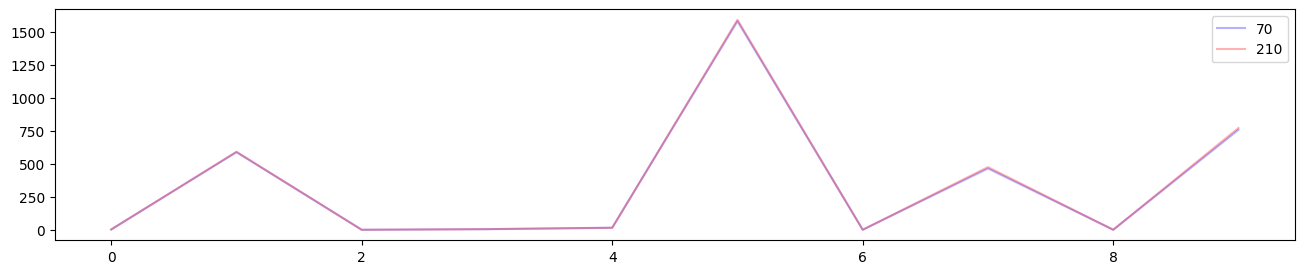

In [13]:
for i in range(0, len(sub_old), 500):
    fig, ax = plt.subplots(figsize=(16, 3))
    ax.plot(sub_old["target"][i:i+10], "b-", label="70", alpha=0.3)
    ax.plot(sub_new["target"][i:i+10], "r-", label="210", alpha=0.3)
    ax.legend()
    plt.show()
    break

### *Time Identifiers*

In [1]:
from datetime import datetime, timedelta

In [2]:
import polars  as pl
train = pl.read_parquet("./data/processed/data_eager_tgt.parquet")

In [3]:
holidays = pl.read_csv("./data/raw/open_src/holidays.csv")
if "date" not in train:
    train = train.with_columns(pl.col("datetime").dt.date().alias("date"))

In [4]:
tid_feats = [
    pl.col("datetime").dt.quarter().alias("quarter"),
    pl.col("datetime").dt.month().alias("month"),
    pl.col("datetime").dt.day().alias("day"),
    pl.col("datetime").dt.weekday().alias("weekday"),
    pl.col("datetime").dt.hour().alias("hour"),
    # ===
    # Can convert to other encoding (e.g., sin/cos)
    pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
    # ===
]

In [5]:
ds, de = datetime(2021, 9, 1), datetime(2024, 12, 31)
date_range = [ds + timedelta(days=d) for d in range((de - ds).days + 1)]
date_df = pl.DataFrame({"date": date_range}).with_columns(pl.col("date").cast(pl.Date))
holidays = (
    holidays
    .select(["date", "holiday_type"])
    .with_columns(pl.col("date").cast(pl.Date))
)
holidays = (
    date_df
    .join(holidays, on="date", how="left")
    .fill_null(0)
    .unique(subset=["date"])
    .rename({"date": "holiday_date"})
)

In [6]:
train = (
    train
    .rename({"date": "holiday_date"})
    .with_columns(tid_feats)
    .join(holidays, on=["holiday_date"], how="left")
    .drop("holiday_date")
)

In [106]:
# Use 2pi radian as base to derive timestamp encoding
train = (
    train
    .with_columns(
        (np.pi * pl.col("dayofyear") / 183).sin().alias("dayofyear_sin"),
        (np.pi * pl.col("dayofyear") / 183).cos().alias("dayofyear_cos"),
        (np.pi * pl.col("hour") / 12).sin().alias("hour_sin"),
        (np.pi * pl.col("hour") / 12).cos().alias("hour_cos"),
    )
)
train.head()

county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_lag2d,installed_capacity_lag2d,temperature_local_mean,dewpoint_local_mean,cloudcover_high_local_mean,cloudcover_low_local_mean,cloudcover_mid_local_mean,cloudcover_total_local_mean,10_metre_u_wind_component_local_mean,10_metre_v_wind_component_local_mean,direct_solar_radiation_local_mean,surface_solar_radiation_downwards_local_mean,snowfall_local_mean,total_precipitation_local_mean,temperature_global_mean,dewpoint_global_mean,cloudcover_high_global_mean,cloudcover_low_global_mean,cloudcover_mid_global_mean,cloudcover_total_global_mean,10_metre_u_wind_component_global_mean,10_metre_v_wind_component_global_mean,direct_solar_radiation_global_mean,surface_solar_radiation_downwards_global_mean,snowfall_global_mean,total_precipitation_global_mean,temperature_local_mean_hist_lag2d,dewpoint_local_mean_hist_lag2d,…,rain_global_mean_hist_lag7d,snowfall_global_mean_hist_lag7d,surface_pressure_global_mean_hist_lag7d,cloudcover_total_global_mean_hist_lag7d,cloudcover_low_global_mean_hist_lag7d,cloudcover_mid_global_mean_hist_lag7d,cloudcover_high_global_mean_hist_lag7d,windspeed_10m_global_mean_hist_lag7d,winddirection_10m_global_mean_hist_lag7d,shortwave_radiation_global_mean_hist_lag7d,direct_solar_radiation_global_mean_hist_lag7d,diffuse_radiation_global_mean_hist_lag7d,target_div_cap_lag2d,target_div_eic_lag2d,target_lag2d_prod,target_lag3d_prod,target_lag4d_prod,target_lag5d_prod,target_lag6d_prod,target_lag7d_prod,target_lag2d_cons,target_lag3d_cons,target_lag4d_cons,target_lag5d_cons,target_lag6d_cons,target_lag7d_cons,quarter,month,day,weekday,hour,dayofyear,holiday_type,dayofyear_sin,dayofyear_cos,hour_sin,hour_cos
i8,i8,i8,f32,i8,datetime[μs],i16,i32,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u32,u32,u32,u32,u32,u32,i64,f64,f64,f64,f64
0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,9,1,3,0,244,0,-0.866025,-0.5,0.0,1.0
0,0,1,96.589996,1,2021-09-01 00:00:00,0,1,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,9,1,3,0,244,0,-0.866025,-0.5,0.0,1.0
0,0,2,0.0,0,2021-09-01 00:00:00,0,2,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,9,1,3,0,244,0,-0.866025,-0.5,0.0,1.0
0,0,2,17.313999,1,2021-09-01 00:00:00,0,3,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,9,1,3,0,244,0,-0.866025,-0.5,0.0,1.0
0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3,9,1,3,0,244,0,-0.866025,-0.5,0.0,1.0


In [107]:
# a = train.select(["dayofyear", "dayofyear_sin"]).unique().sort("dayofyear")
# b = train.select(["dayofyear", "dayofyear_cos"]).unique().sort("dayofyear")

# fig, ax = plt.subplots()
# ax.plot(a["dayofyear"], a["dayofyear_sin"], "r-", label="sin")
# ax.plot(b["dayofyear"], b["dayofyear_cos"], "g-", label="cos")
# ax.legend()
# plt.show()

In [7]:
train.write_parquet("./data/processed/data_eager_new.parquet")

## Feature Version Control

In [5]:
FEAT_VER_PATH = PROC_DATA_PATH / "feats"

NameError: name 'PROC_DATA_PATH' is not defined

In [6]:
# Features commonly shared among versions
tid_feats = ['quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', "holiday_type"]

### *Submission Debug*
> Use `v1n` for debugging.

In [111]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
)

with open("./data/processed/feats/v1_debug.pkl", "wb") as f:
    pickle.dump(feats, f)

### *Pinned Base Features*

> Compare other feature sets with this set and take notes (*e.g.,* the difference, the effectiveness).

In [21]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)

with open("./data/processed/feats/v1n.pkl", "wb") as f:
    pickle.dump(feats, f)

In [22]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
)

with open("./data/processed/feats/v2n.pkl", "wb") as f:
    pickle.dump(feats, f)

### *Add Timestamp Encoding*
Similar to **positional encoding**.

In [15]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["hour_sin", "hour_cos", "dayofyear_sin", "dayofyear_cos"]
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)

with open("./data/processed/feats/v3n.pkl", "wb") as f:
    pickle.dump(feats, f)

In [16]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["hour_sin", "hour_cos", "dayofyear_sin", "dayofyear_cos"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
)

with open("./data/processed/feats/v4n.pkl", "wb") as f:
    pickle.dump(feats, f)

### *Add Historical Weather Lag2d*

In [21]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + [c for c in train.columns if c.endswith("_local_mean_hist_lag2d")]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)

with open("./data/processed/feats/v5n.pkl", "wb") as f:
    pickle.dump(feats, f)

In [22]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + [c for c in train.columns if c.endswith("_local_mean_hist_lag2d")]
)

with open("./data/processed/feats/v6n.pkl", "wb") as f:
    pickle.dump(feats, f)

### *Add Historical Weathe Lag7d*

In [27]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + [c for c in train.columns if c.endswith("_local_mean_hist_lag7d")]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)

with open("./data/processed/feats/v7n.pkl", "wb") as f:
    pickle.dump(feats, f)

In [28]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + [c for c in train.columns if c.endswith("_local_mean_hist_lag7d")]
)

with open("./data/processed/feats/v8n.pkl", "wb") as f:
    pickle.dump(feats, f)

### 

In [63]:
len([c for c in train.columns if re.search("_(lb|lp|gb|gp)_", c) and "div" not in c])

48

In [7]:
train = pl.read_parquet("./data/processed/data_eager_tgt.parquet")

In [8]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    # + [c for c in train.columns if re.search("_(lb|lp|gb|gp)_", c) and "div" not in c]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + [c for c in train.columns if c.endswith("_local_mean_hist_lag7d")]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)

with open("./data/processed/feats/v9n.pkl", "wb") as f:
    pickle.dump(feats, f)

In [70]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in train.columns if re.search("_(lb|lp|gb|gp)_", c) and "div" in c]
    + [c for c in train.columns if c.endswith("_local_mean")]
    + [c for c in train.columns if c.endswith("_local_mean_hist_lag7d")]
)

with open("./data/processed/feats/v10n.pkl", "wb") as f:
    pickle.dump(feats, f)

## Model Combination

In [18]:
import pickle

In [19]:
OUTPUT_DIR = Path("./output")

In [39]:
exp_id = "1230-01_43_54"
prod_exp_id = "1230-00_51_20"
cons_c_exp_id = "1230-00_58_55"
cons_b_exp_id = "1230-01_41_51"

In [43]:
models = {}

In [46]:
with open(OUTPUT_DIR / prod_exp_id / "models/models_ft.pkl", "rb") as f:
    models["prod"] = pickle.load(f)["prod"]
with open(OUTPUT_DIR / cons_c_exp_id / "models/models_ft.pkl", "rb") as f:
    models["cons_c"] = pickle.load(f)["cons_c"]
with open(OUTPUT_DIR / cons_b_exp_id / "models/models_ft.pkl", "rb") as f:
    models["cons_b"] = pickle.load(f)["cons"]
for k, v in models.items():
    print(k, len(v))
    print(v[0].feature_names_in_)

prod 3
['county' 'is_business' 'product_type' 'quarter' 'month' 'day' 'weekday'
 'hour' 'dayofyear' 'holiday_type' 'target_div_cap_lag2d_lag2d_prod'
 'target_div_cap_lag2d_lag3d_prod' 'target_div_cap_lag2d_lag4d_prod'
 'target_div_cap_lag2d_lag5d_prod' 'target_div_cap_lag2d_lag6d_prod'
 'target_div_cap_lag2d_lag7d_prod' 'target_div_cap_lag2d_lag2d_cons'
 'target_div_cap_lag2d_lag3d_cons' 'target_div_cap_lag2d_lag4d_cons'
 'target_div_cap_lag2d_lag5d_cons' 'target_div_cap_lag2d_lag6d_cons'
 'target_div_cap_lag2d_lag7d_cons' 'temperature_local_mean'
 'dewpoint_local_mean' 'cloudcover_high_local_mean'
 'cloudcover_low_local_mean' 'cloudcover_mid_local_mean'
 'cloudcover_total_local_mean' '10_metre_u_wind_component_local_mean'
 '10_metre_v_wind_component_local_mean'
 'direct_solar_radiation_local_mean'
 'surface_solar_radiation_downwards_local_mean' 'snowfall_local_mean'
 'total_precipitation_local_mean']
cons_c 3
['county' 'product_type' 'quarter' 'month' 'day' 'weekday' 'hour'
 'dayofyea

In [47]:
with open(OUTPUT_DIR / exp_id / "models/models_ft.pkl", "wb") as f:
    pickle.dump(models, f)

In [26]:
exp_id = "1230-04_29_00"
prod_exp_id = "1230-04_28_46"
cons_c_exp_id = "1230-04_28_46"
cons_b_exp_id = "1230-04_16_52"

In [27]:
models = {}

In [28]:
with open(OUTPUT_DIR / prod_exp_id / "models/models_ft.pkl", "rb") as f:
    models_tmp = pickle.load(f)
    models["prod"] = models_tmp["prod"]
    models["cons_c"] = models_tmp["cons_c"]
with open(OUTPUT_DIR / cons_b_exp_id / "models/models_ft.pkl", "rb") as f:
    models["cons_b"] = pickle.load(f)["cons"]
for k, v in models.items():
    print(k, len(v))
    print(v[0].feature_names_in_)

prod 1
['county' 'is_business' 'product_type' 'quarter' 'month' 'day' 'weekday'
 'hour' 'dayofyear' 'holiday_type' 'target_div_cap_lag2d_lag2d_prod'
 'target_div_cap_lag2d_lag3d_prod' 'target_div_cap_lag2d_lag4d_prod'
 'target_div_cap_lag2d_lag5d_prod' 'target_div_cap_lag2d_lag6d_prod'
 'target_div_cap_lag2d_lag7d_prod' 'target_div_cap_lag2d_lag2d_cons'
 'target_div_cap_lag2d_lag3d_cons' 'target_div_cap_lag2d_lag4d_cons'
 'target_div_cap_lag2d_lag5d_cons' 'target_div_cap_lag2d_lag6d_cons'
 'target_div_cap_lag2d_lag7d_cons' 'temperature_local_mean'
 'dewpoint_local_mean' 'cloudcover_high_local_mean'
 'cloudcover_low_local_mean' 'cloudcover_mid_local_mean'
 'cloudcover_total_local_mean' '10_metre_u_wind_component_local_mean'
 '10_metre_v_wind_component_local_mean'
 'direct_solar_radiation_local_mean'
 'surface_solar_radiation_downwards_local_mean' 'snowfall_local_mean'
 'total_precipitation_local_mean']
cons_c 1
['county' 'product_type' 'quarter' 'month' 'day' 'weekday' 'hour'
 'dayofyea

In [29]:
with open(OUTPUT_DIR / exp_id / "models/models_ft.pkl", "wb") as f:
    pickle.dump(models, f)